In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import numpy as np

import sys

sys.path.append('..')

from sast.utils import *
from sast.usast import *

from interpret import show
from interpret.blackbox import LimeTabular

from sktime.transformations.panel.rocket import Rocket

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sktime.classification.dictionary_based import MUSE
from sklearn.pipeline import Pipeline

import seaborn as sns
sns.set()

/Users/michael/opt/miniconda3/envs/sast/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:42: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/Users/michael/opt/miniconda3/envs/sast/lib/python3.9/site-packages/sktime/datatypes/_panel/_check.py:45: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/Users/michael/opt/miniconda3/envs/sast/lib/python3.9/site-packages/sktime/datatypes/_panel/_check.py:46: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_MULTIINDEX_TYPES = (pd.Int64Index, pd.Ra

In [2]:
idx = 0 # intance to be explained

# Explain PLAsTiCC

In [4]:
bands = 'giruyz'
dataset_name = 'plassticc_5d'
#dataset_folder = '/home/mimbouop/Codes/UST-Python/dataset/plasticc_5d_dataset'
dataset_folder = '/Users/michael/Desktop/Code/ustc/dataset/plasticc_5d_dataset/'
keep_classes = None 

base_folder = '/Users/michael/Downloads/models-m20-M64-ls10/' # saved models
# base_folder = '/home/mimbouop/Téléchargements/models-m20-M64-ls10/models/'

## Explain XEM

In [5]:
def read_uncertain_data(folder, dataset, keep_classes=None):
	_, _, test_ds, test_ds_err = load_uncertain_dataset(dataset_folder, dataset)
	
	X_test, X_test_err, y_test = format_uncertain_dataset(test_ds, test_ds_err, shuffle=False)

	if keep_classes is not None:
		keep_test = [c in keep_classes for c in y_test]

		y_test = y_test[keep_test]
		X_test = X_test[keep_test]
		X_test_err = X_test_err[keep_test]

	return X_test, X_test_err, y_test

In [10]:
X_test, X_test_err, y_test = {}, {}, None

for b in bands:
    X_test[b], X_test_err[b], y_test = read_uncertain_data(dataset_folder, dataset_name+'_'+b)

In [45]:
def xem_explaination(mts_id, reg_start, reg_end, pred_class):
    print("Explanation for MTS:", mts_id, "Class:" , y_test[mts_id], 'Prediction:', pred_class)
    nrows, ncols = 2, 3
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, tight_layout=True, figsize=(10, 5))

    for i, b in enumerate(bands):
        row, col = i // ncols, i - ncols * (i // 3)
        ax = axes[row,col]
        x, y, yerr = range(X_test[b][mts_id].size), X_test[b][mts_id], X_test_err[b][mts_id]
        ax.errorbar(y=y, x=x, yerr=yerr, ecolor='r', color='blue')

        x_reg = np.arange(reg_start, reg_end + 1)
        ax.errorbar(y=y[x_reg], x=x_reg, yerr=yerr[x_reg], ecolor='r', color='blue', lw=5)

        ax.set_title(f'Dimension: {b}', fontsize=15)
        if row == nrows - 1:
            ax.set_xlabel('Timestep', fontsize=15)
        if col == 0:
            ax.set_ylabel('Flux', fontsize=15)
    return fig

Using MTS regions from '../XEM/results/plasticc-T2-run1/window_20/xp_1/xem.out'

Explanation for MTS: 0 Class: 90 Prediction: 90


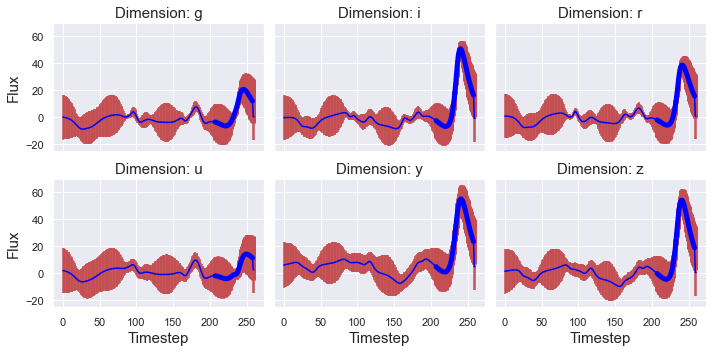

In [46]:
mts_id, pred_class = 0, 90
reg_start, reg_end = 207, 258
fig = xem_explaination(mts_id, reg_start, reg_end, pred_class)

Explanation for MTS: 1 Class: 42 Prediction: 16


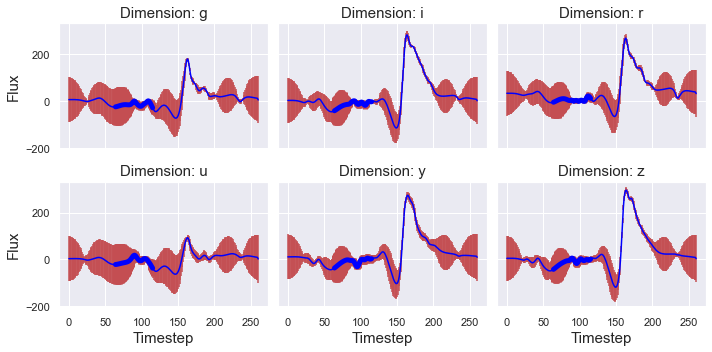

In [48]:
mts_id, pred_class = 1, 16
reg_start, reg_end = 64, 115
fig = xem_explaination(mts_id, reg_start, reg_end, pred_class)

Explanation for MTS: 2 Class: 15 Prediction: 15


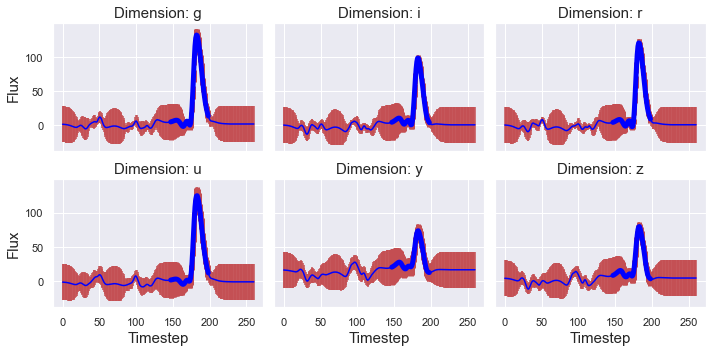

In [49]:
mts_id, pred_class = 2, 15
reg_start, reg_end = 147, 198
fig = xem_explaination(mts_id, reg_start, reg_end, pred_class)

Explanation for MTS: 3 Class: 90 Prediction: 90


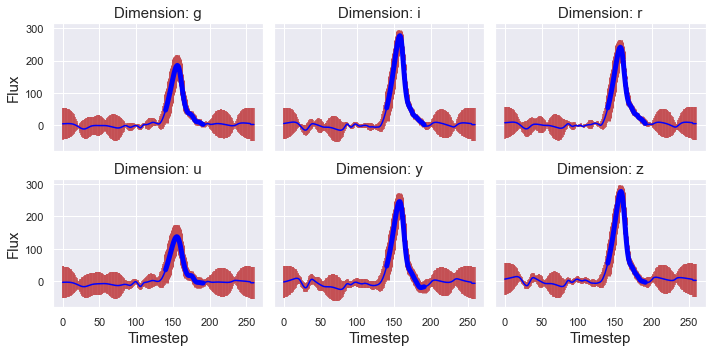

In [50]:
mts_id, pred_class = 3, 90
reg_start, reg_end = 140, 191
fig = xem_explaination(mts_id, reg_start, reg_end, pred_class)

Explanation for MTS: 8 Class: 52 Prediction: 90


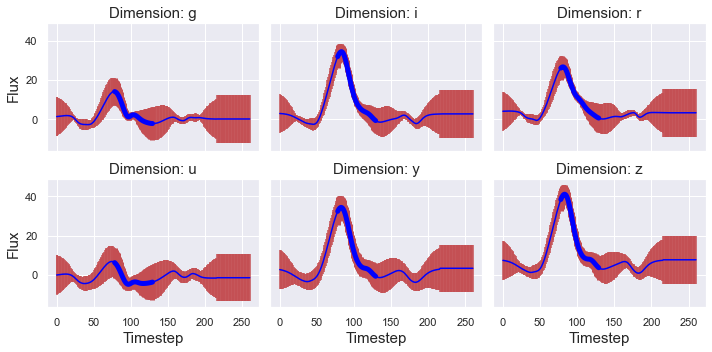

In [51]:
mts_id, pred_class = 8, 90
reg_start, reg_end = 78, 129
fig = xem_explaination(mts_id, reg_start, reg_end, pred_class)

Explanation for MTS: 152 Class: 42 Prediction: 42


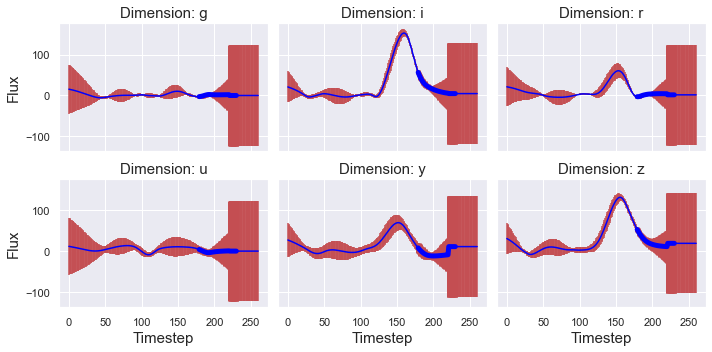

In [65]:
mts_id, pred_class = 152, 42
reg_start, reg_end = 179, 230
fig = xem_explaination(mts_id, reg_start, reg_end, pred_class)

Explanation for MTS: 61 Class: 62 Prediction: 62


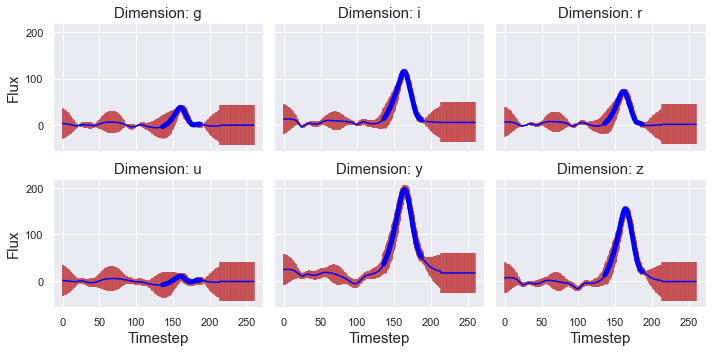

In [61]:
mts_id, pred_class = 61, 62
reg_start, reg_end = 136, 187
fig = xem_explaination(mts_id, reg_start, reg_end, pred_class)

## Explain uSAST

In [8]:
usast_g = joblib.load(base_folder + 'u_plassticc_5d_sast_g_cFalse_dTrue_s1_runno2.joblib')
usast_i = joblib.load(base_folder + 'u_plassticc_5d_sast_i_cFalse_dTrue_s1_runno2.joblib')
usast_r = joblib.load(base_folder + 'u_plassticc_5d_sast_r_cFalse_dTrue_s1_runno2.joblib')
usast_u = joblib.load(base_folder + 'u_plassticc_5d_sast_u_cFalse_dTrue_s1_runno2.joblib')
usast_y = joblib.load(base_folder + 'u_plassticc_5d_sast_y_cFalse_dTrue_s1_runno2.joblib')
usast_z = joblib.load(base_folder + 'u_plassticc_5d_sast_z_cFalse_dTrue_s1_runno2.joblib')

/Users/michael/opt/miniconda3/envs/sast/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RidgeClassifierCV from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/michael/opt/miniconda3/envs/sast/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [9]:
usast = {}
ts_transform = [[]]
ts_transform_err = [[]]

for b in bands:
    usast[b] = joblib.load(f'{base_folder}u_plassticc_5d_sast_{b}_cFalse_dTrue_s1_runno2.joblib')
    #tmp, tmp_err = usast[b].transform(X_test[b][idx:idx+1], X_test_err[b][idx:idx+1])
    #ts_transform = np.concatenate([ts_transform, tmp], axis=1)
    #ts_transform_err = np.concatenate([ts_transform_err, tmp_err], axis=1)
    
#final_ts_tranform = np.concatenate([ts_transform, ts_transform_err], axis=1)
#final_ts_tranform

In [ ]:
transformed_plasticc_train = joblib.load('plasticc_train_transform.np')

In [10]:
xgb_clf = joblib.load(base_folder + 'xgb_u_plassticc_5d_cFalse_dTrue_s1_runno2.joblib')
xgb_clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=64,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [ ]:
lime = LimeTabular(predict_fn=xgb_clf.predict_proba, data=X_train_transform)
lime_local = lime.explain_local(final_ts_tranform, y_test[idx])

show(lime_local)

In [11]:
"""
expected_n_features = (usast_g.n_kernels_no_duplicates + 
 usast_i.n_kernels_no_duplicates + 
 usast_r.n_kernels_no_duplicates + 
 usast_u.n_kernels_no_duplicates + 
 usast_y.n_kernels_no_duplicates + 
 usast_z.n_kernels_no_duplicates) * 3 # three because we have [best guesses, counts, uncertainties]

fi = xgb_clf.feature_importances_
n_features = len(fi)

assert n_features == expected_n_features, 'There is problem with the number of features'

m_len = n_features // 3

best_guess_features_indices = [0, m_len - 1]
count_featues_indices = [m_len, 2*m_len - 1]
err_features_indices = [2*m_len, n_features - 1]

print('Best guess features indices: ', best_guess_features_indices)
print('Count features indices: ', count_featues_indices)
print('Uncertainties features indices: ', err_features_indices)
"""

expected_n_features = (usast_g.n_kernels_no_duplicates + 
 usast_i.n_kernels_no_duplicates + 
 usast_r.n_kernels_no_duplicates + 
 usast_u.n_kernels_no_duplicates + 
 usast_y.n_kernels_no_duplicates + 
 usast_z.n_kernels_no_duplicates) * 2 # two because we have [best guesses, uncertainties]

fi = xgb_clf.feature_importances_
n_features = len(fi)

assert n_features == expected_n_features, f'There is problem with the number of features. The classifier has {n_features} and the expected numbers is {expected_n_features}'

m_len = n_features // 2

best_guess_features_indices = [0, m_len - 1]
err_features_indices = [m_len, n_features - 1]

print('Best guess features indices: ', best_guess_features_indices)
print('Uncertainties features indices: ', err_features_indices)

Best guess features indices:  [0, 80251]
Uncertainties features indices:  [80252, 160503]


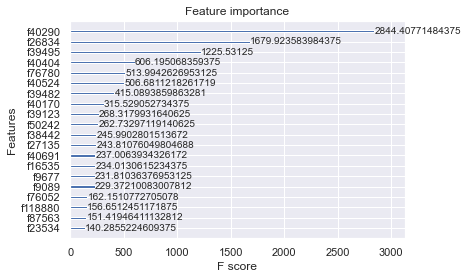

In [12]:
xgb.plot_importance(xgb_clf, max_num_features=20, importance_type='gain');

In [13]:
feature_sorter = np.argsort(xgb_clf.feature_importances_)[::-1]

k = 100 # number of top bests

feature_sorter_topk = feature_sorter[:k]
feature_sorter_topk

array([ 40290,  26834,  39495,  40404,  76780,  40524,  39482,  40170,
        39123,  50242,  38442,  27135,  40691,  16535,   9677,   9089,
        76052, 118880,  87563,  23534,  53848, 141881,  92027, 118891,
        50200,  72478,  40773,  25194,  13796,  90616,  37655,  69698,
        45264,  54690,  65166,  39718,  65853,  19526,  24049,  40360,
        90756,   8014,  73961,   9417, 158600, 103433,    768,  78637,
        27191,  91113, 137892,  65151,  25918,  46543,  60560,  78516,
        14772,  77577, 120900,  26420, 105521,  72236,  12609,  66411,
       128644,  32351,  19362, 139231,  51112, 142806, 105683,  75440,
        36689, 105016,  20734,  39735,  67435, 149543,  64535,   2510,
        71861,  44344,  66472, 109648, 159338,  78876,  35716,  14788,
        50350,  57775,  60811,  76896,  87568,  40388,  22031, 119709,
        20151,  22649,  19811, 114828])

In [14]:
FK_BEST= 'Value'
FK_COUNT = 'Count'
FK_ERR = 'Uncertainty'

def get_kind(idx):
    if idx >= best_guess_features_indices[0] and idx <= best_guess_features_indices[1]:
        return FK_BEST
    if idx >= err_features_indices[0] and idx <= err_features_indices[1]:
        return FK_ERR
    return FK_COUNT

feature_kinds = pd.DataFrame(data=[get_kind(idx) for idx in feature_sorter], index=feature_sorter)
feature_kinds.value_counts()

Uncertainty    80252
Value          80252
dtype: int64

In [21]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

def get_usast_kernel_by_index(index, usast_clf):
    """
    Return the kernel (i.e subsequence) associated to the input `index`
    """
    curr_pos = 0
    kernel = None
    kernel_err = None
    dim_index = 0
    
    for k in usast_clf.kernels_dict.keys():
        n_k = usast_clf.kernels_dict[k].shape[0]
        
        if index < curr_pos + n_k:
            kernel = usast_clf.kernels_dict[k][index-curr_pos]
            kernel_err = usast_clf.kernels_err_dict[k][index-curr_pos]
            break
        else:
            curr_pos += n_k
            dim_index += 1
    
    assert kernel is not None, 'Kernel index out of bound'
    
    return kernel.astype(np.float64), kernel_err.astype(np.float64), dim_index

def find_best_match(ts, ts_err, arr, arr_err):
    """Return best match position
    """

    m = len(ts)
    l = len(arr)
    best_dist = np.inf
    best_dist_err = np.inf 
    best_pos = 0

    arr_norm, arr_norm_err = znormalize_uncertain_array(arr, arr_err)

    for i in range(m - l + 1):
        ts_norm, ts_norm_err = znormalize_uncertain_array(ts[i:i+l], ts_err[i:i+l])
        dif = ts_norm - arr_norm
        dist = np.sum(dif**2)
        dist_err = 2 * np.sum(np.abs(dif)*(ts_norm_err+arr_norm_err))

        #We use the simple ordering strategy to compare the uncertain similarities.
        if (dist < best_dist) or ((dist == best_dist) and (dist_err < best_dist_err)):
            best_dist = dist
            best_dist_err = dist_err
            best_pos = i

    return best_pos, best_dist, best_dist_err

def find_best_matching_generator(kernel, kernel_err, usast_clf):
    """
    Find the best matching generator of the kernel
    """
    
    best_match_dist = np.inf
    best_match_dist_err = np.inf
    best_match_class = None
    best_gen = None
    
    for c, gens in usast_clf.kernels_generators_.items():
        
        for i in range(gens.shape[0]):
            gen = gens[i].astype(np.float64)
            gen_err = usast_clf.kernels_generators_err_[c][i].astype(np.float64)
            best_pos, best_dist, best_dist_err = find_best_match(gen, gen_err, kernel, kernel_err)
            
            if best_dist < best_match_dist or ((best_dist == best_match_dist) and (best_dist_err < best_match_dist_err)):
                best_match_class = c
                best_match_dist = best_dist
                best_match_dist_err = best_dist_err
                best_gen = (gen, gen_err)
    
    return best_gen, best_match_class, (best_match_dist, best_match_dist_err)
    
def plot_kernel_on_generators(kernel, kernel_err, usast_clf, title='', fname=None, only_classes=None):
    """
    Plot the input kernel over each reference time series in the classifier and returns the class of the best match
    """
    
    fig = plt.figure(figsize=(8, 4))
    sp_idx = 1
    
    best_match_dist = np.inf
    best_match_dist_err = np.inf
    best_match_class = None
    best_gen = None
    
    for c, gens in usast_clf.kernels_generators_.items():
        
        for i in range(gens.shape[0]):
            gen = gens[i]
            gen_err = usast_clf.kernels_generators_err_[c][i]
            best_pos, best_dist, best_dist_err = find_best_match(gen, gen_err, kernel, kernel_err)
            
            if best_dist < best_match_dist or ((best_dist == best_match_dist) and (best_dist_err < best_match_dist_err)):
                best_match_class = c
                best_match_dist = best_dist
                best_match_dist_err = best_dist_err
                best_gen = gen
                best_gen_err = gen_err
                
            if best_dist == 0 and (only_classes is None or best_match_class in only_classes):
                plt.errorbar(np.arange(best_gen.size), best_gen, best_gen_err[:-1], ecolor='red', c='blue')
                plt.errorbar(np.arange(best_pos, best_pos + kernel.size), kernel, kernel_err, ecolor='red', lw=5, c='blue')
                plt.suptitle(title+f', Class: {c}', fontweight='bold', fontsize=15)
                plt.xticks(fontsize=15)
                plt.yticks(fontsize=15)
                plt.xlabel('Timestep', fontsize=15)
                plt.ylabel('Flux', fontsize=15)
                
                ax = plt.gca()
                axins = inset_axes(ax, 3, 1.2, loc="upper right", bbox_to_anchor=[1.3, 0.95], bbox_transform=ax.figure.transFigure)
                axins.errorbar(np.arange(best_pos, best_pos + kernel.size), kernel, kernel_err, ecolor='red', c='blue')
                axins.set_title(f'Length={kernel.size}')
                x1, x2, y1, y2 = best_pos, best_pos+kernel.size, min(kernel - kernel_err), max(kernel + kernel_err)
                axins.set_xlim(x1, x2)
                axins.set_ylim(y1, y2)
                
                #plt.xticks(visible=False)
                #plt.yticks(visible=False)

                print('Best match in class', best_match_class, 'with distance', best_match_dist, '+/-', best_match_dist_err)
                
                mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
                
                plt.tight_layout()
                
                if fname:
                    plt.savefig(fname, bbox_inches='tight')
                
                plt.show()
    
    return best_match_class
    
def get_kernel_index_and_clf(idx, kind, models=(usast_g, usast_i, usast_r, usast_u, usast_y, usast_z)):
    """Return the clf from with the kernel came from and the corresponding position in that model's list of kernels
    """
    curr = 0
    pos = -1
    model = None
    
    if kind == FK_ERR:
        idx -= (n_features // 2)
    
    for m in models:
        if idx < m.n_kernels_no_duplicates + curr:
            pos = idx - curr
            model = m
            break
        else:
            curr += m.n_kernels_no_duplicates
            
    assert model is not None, 'Kernel index out of bound'
    
    return pos, model

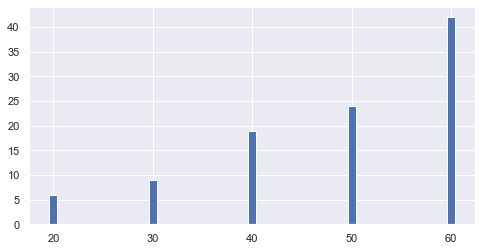

In [28]:
feature_lengths = np.zeros(k)
for i, s in enumerate(feature_sorter_topk):
    pos, model = get_kernel_index_and_clf(s, feature_kinds.loc[s, 0])
    kernel, kernel_err, _ = get_usast_kernel_by_index(pos , model)
    feature_lengths[i] = len(kernel)
    
counts = np.bincount(feature_lengths.astype(int))
barX = np.nonzero(counts)[0]
barH = counts[barX]

plt.figure(figsize=(8, 4))
plt.bar(barX, barH)
plt.xticks(barX)
plt.show()

#### Plot most important features

In [16]:
# sources https://sashamaps.net/docs/resources/20-colors/
color_list = ['#000000', '#800000', '#006400', '#4b0082', '#b8860b', 
              '#000080', '#00ced1', '#ffff00', '#c71585', '#00ff00', 
              '#0000ff', '#ff00ff', '#6495ed', '#ff8c00']
class2color = dict()
for i, c in enumerate(xgb_clf.classes_):
    class2color[c] = color_list[i]
class2color

{6: '#000000',
 15: '#800000',
 16: '#006400',
 42: '#4b0082',
 52: '#b8860b',
 53: '#000080',
 62: '#00ced1',
 64: '#ffff00',
 65: '#c71585',
 67: '#00ff00',
 88: '#0000ff',
 90: '#ff00ff',
 92: '#6495ed',
 95: '#ff8c00'}

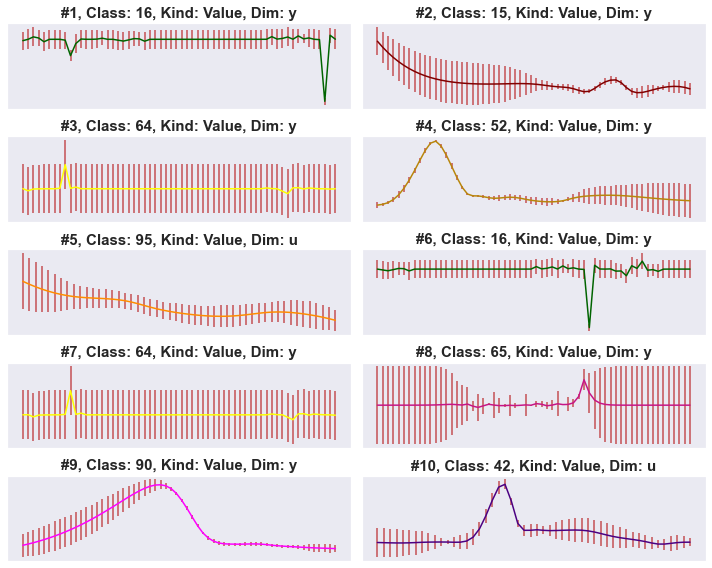

In [35]:
plt.figure(figsize=(10, 8))

for i, index in enumerate(feature_sorter_topk[:10]):
    pos, model = get_kernel_index_and_clf(index, feature_kinds.loc[index, 0])
    kernel, kernel_err, dim_index = get_usast_kernel_by_index(pos , model)
    _, best_match_class, _ = find_best_matching_generator(kernel.astype(np.float64), kernel_err.astype(np.float64), model)

    plt.subplot(5, 2, i+1)
    plt.errorbar(x=range(len(kernel)), y=kernel, yerr=kernel_err, ecolor='r', color=class2color[best_match_class])
    plt.title(f'#{i+1}, Class: {best_match_class}, Kind: {feature_kinds.loc[index, 0]}, Dim: {bands[dim_index]}', fontweight='bold', fontsize=15)
    plt.yticks([])
    plt.xticks([])
plt.tight_layout()
plt.savefig('../images/10-top-plasticc-subsequences.pdf')

#### Plot most important features on generators

Most important feature  0  Kind = Value
Kernel length: 60 dim: 4
Best match in class 16 with distance 0.0 +/- 0.0


/var/folders/fk/w9869w_54mg2qlmhzyjfjvdm0000gq/T/ipykernel_56880/2377489553.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


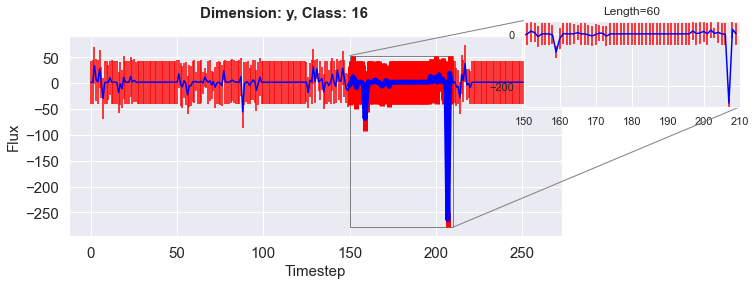

Most important feature  1  Kind = Value
Kernel length: 60 dim: 4
Best match in class 15 with distance 0.0 +/- 0.0


/var/folders/fk/w9869w_54mg2qlmhzyjfjvdm0000gq/T/ipykernel_56880/2377489553.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


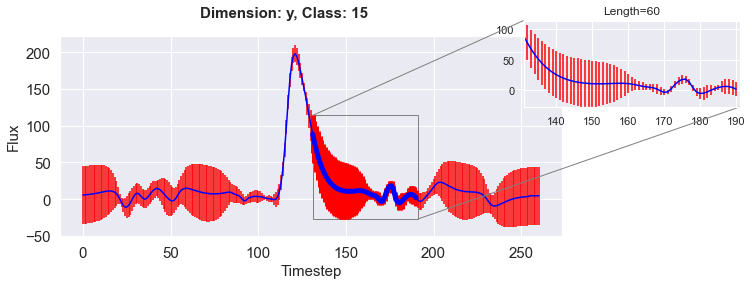

Most important feature  2  Kind = Value
Kernel length: 60 dim: 4
Best match in class 64 with distance 0.0 +/- 0.0


/var/folders/fk/w9869w_54mg2qlmhzyjfjvdm0000gq/T/ipykernel_56880/2377489553.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


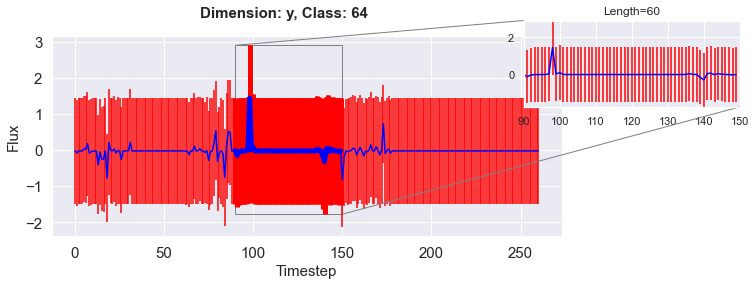

Most important feature  3  Kind = Value
Kernel length: 60 dim: 4
Best match in class 52 with distance 0.0 +/- 0.0


/var/folders/fk/w9869w_54mg2qlmhzyjfjvdm0000gq/T/ipykernel_56880/2377489553.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


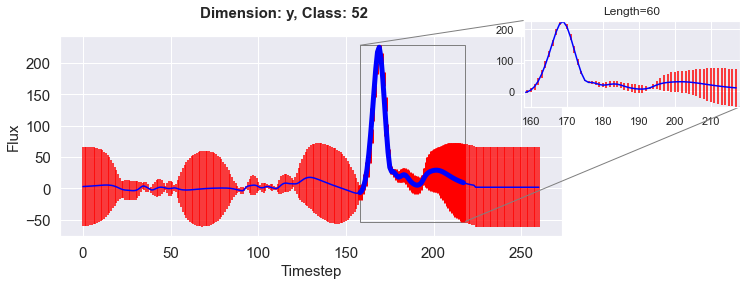

Most important feature  4  Kind = Value
Kernel length: 50 dim: 3
Best match in class 95 with distance 0.0 +/- 0.0


/var/folders/fk/w9869w_54mg2qlmhzyjfjvdm0000gq/T/ipykernel_56880/2377489553.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


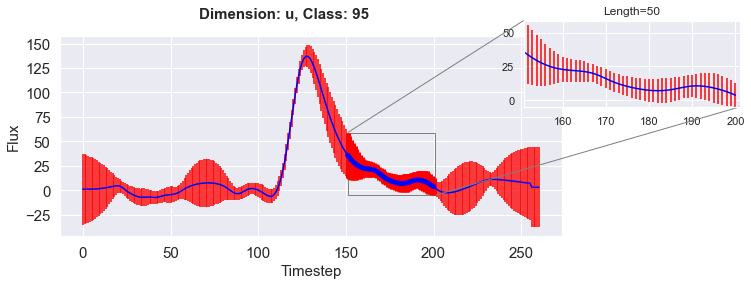

Most important feature  5  Kind = Value
Kernel length: 60 dim: 4
Best match in class 16 with distance 0.0 +/- 0.0


/var/folders/fk/w9869w_54mg2qlmhzyjfjvdm0000gq/T/ipykernel_56880/2377489553.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


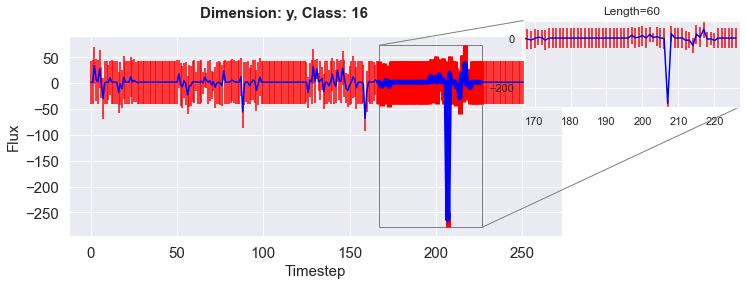

Most important feature  6  Kind = Value
Kernel length: 60 dim: 4
Best match in class 64 with distance 0.0 +/- 0.0


/var/folders/fk/w9869w_54mg2qlmhzyjfjvdm0000gq/T/ipykernel_56880/2377489553.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


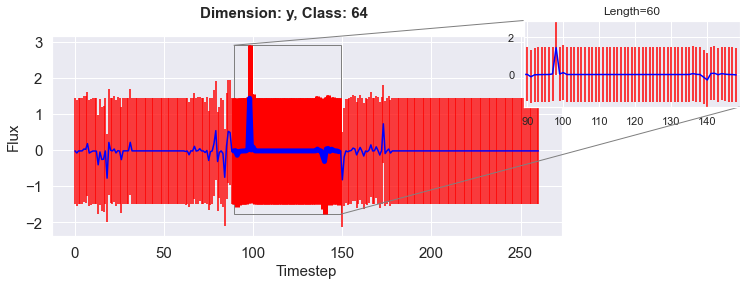

Most important feature  7  Kind = Value
Kernel length: 60 dim: 4
Best match in class 65 with distance 0.0 +/- 0.0


/var/folders/fk/w9869w_54mg2qlmhzyjfjvdm0000gq/T/ipykernel_56880/2377489553.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


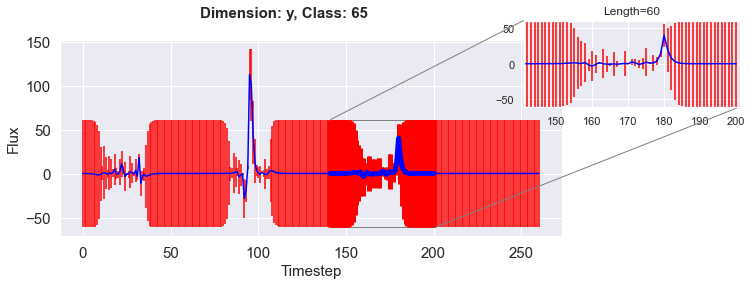

Most important feature  8  Kind = Value
Kernel length: 60 dim: 4
Best match in class 90 with distance 0.0 +/- 0.0


/var/folders/fk/w9869w_54mg2qlmhzyjfjvdm0000gq/T/ipykernel_56880/2377489553.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


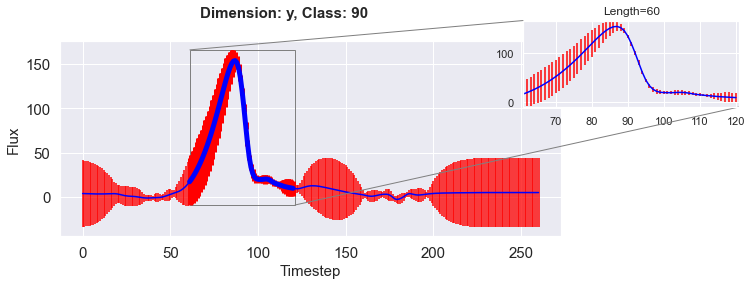

Most important feature  9  Kind = Value
Kernel length: 50 dim: 3
Best match in class 42 with distance 0.0 +/- 0.0


/var/folders/fk/w9869w_54mg2qlmhzyjfjvdm0000gq/T/ipykernel_56880/2377489553.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


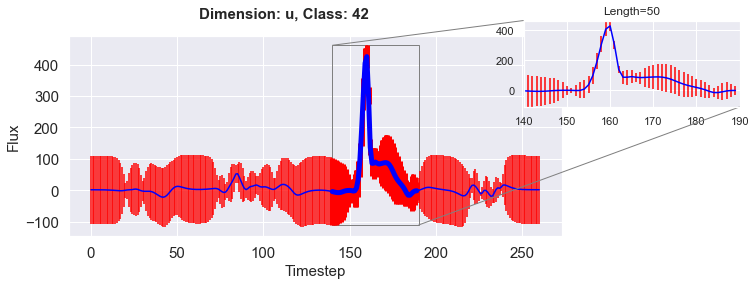

In [159]:
for i, index in enumerate(feature_sorter_topk[:10]):
    print("Most important feature ", i, " Kind =", feature_kinds.loc[index, 0])
    pos, model = get_kernel_index_and_clf(index, feature_kinds.loc[index, 0])
    kernel, kernel_err, dim_idx = get_usast_kernel_by_index(pos , model)
    print('Kernel length:', len(kernel), 'dim:', dim_idx)
    fname=f'../images/most_import_feature_{i}.pdf'
    plot_kernel_on_generators(kernel, kernel_err, model, fname=fname, title=f'Dimension: {bands[dim_idx]}')

Most important feature  0  Kind = Value
Kernel length: 60 dim: 4
Most important feature  1  Kind = Value
Kernel length: 60 dim: 4
Most important feature  2  Kind = Value
Kernel length: 60 dim: 4
Best match in class 64 with distance 0.0 +/- 0.0


/var/folders/fk/w9869w_54mg2qlmhzyjfjvdm0000gq/T/ipykernel_56880/2377489553.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

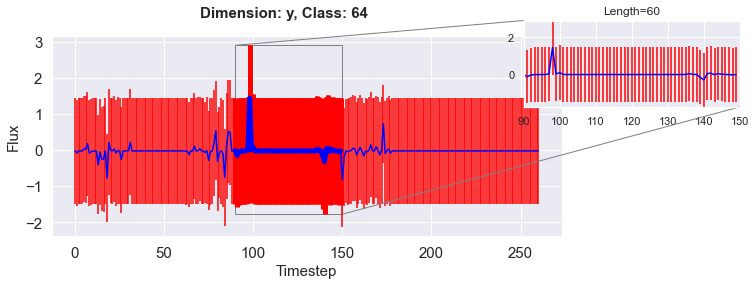

Found to explain class at num 2
Most important feature  3  Kind = Value
Kernel length: 60 dim: 4
Most important feature  4  Kind = Value
Kernel length: 50 dim: 3
Most important feature  5  Kind = Value
Kernel length: 60 dim: 4
Most important feature  6  Kind = Value
Kernel length: 60 dim: 4
Most important feature  7  Kind = Value
Kernel length: 60 dim: 4
Most important feature  8  Kind = Value
Kernel length: 60 dim: 4
Best match in class 90 with distance 0.0 +/- 0.0


/var/folders/fk/w9869w_54mg2qlmhzyjfjvdm0000gq/T/ipykernel_56880/2377489553.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

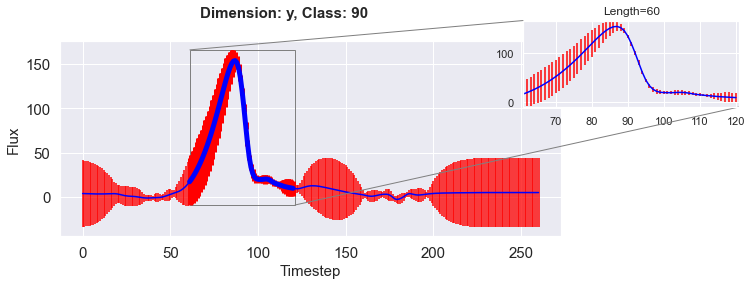

Found to explain class at num 8
Most important feature  9  Kind = Value
Kernel length: 50 dim: 3
Best match in class 42 with distance 0.0 +/- 0.0


/var/folders/fk/w9869w_54mg2qlmhzyjfjvdm0000gq/T/ipykernel_56880/2377489553.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


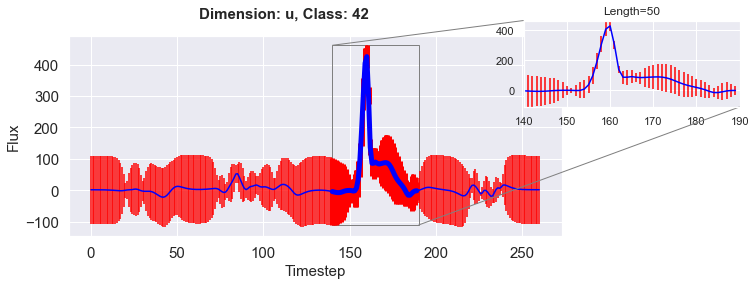

Found to explain class at num 9
Most important feature  10  Kind = Value
Kernel length: 60 dim: 4
Most important feature  11  Kind = Value
Kernel length: 60 dim: 4
Most important feature  12  Kind = Value
Kernel length: 60 dim: 4
Most important feature  13  Kind = Value
Kernel length: 30 dim: 1
Most important feature  14  Kind = Value
Kernel length: 50 dim: 3
Best match in class 62 with distance 0.0 +/- 0.0


/var/folders/fk/w9869w_54mg2qlmhzyjfjvdm0000gq/T/ipykernel_56880/2377489553.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

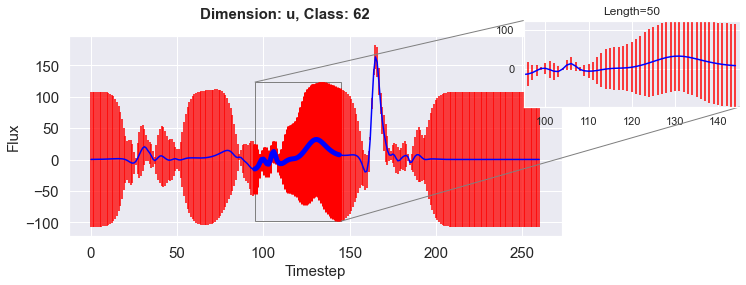

Found to explain class at num 14
Most important feature  15  Kind = Value
Kernel length: 50 dim: 3
Most important feature  16  Kind = Value
Kernel length: 50 dim: 3
Most important feature  17  Kind = Uncertainty
Kernel length: 60 dim: 4
Best match in class 67 with distance 0.0 +/- 0.0


/var/folders/fk/w9869w_54mg2qlmhzyjfjvdm0000gq/T/ipykernel_56880/2377489553.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

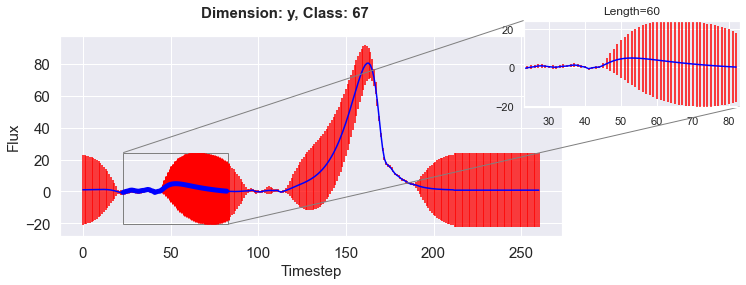

Found to explain class at num 17


In [160]:
to_explain_classes = {90, 67, 62, 64, 42}

for i, index in enumerate(feature_sorter):
    print("Most important feature ", i, " Kind =", feature_kinds.loc[index, 0])
    pos, model = get_kernel_index_and_clf(index, feature_kinds.loc[index, 0])
    kernel, kernel_err, dim_idx = get_usast_kernel_by_index(pos , model)
    print('Kernel length:', len(kernel), 'dim:', dim_idx)
    fname=f'../images/most_import_feature_{i}.pdf'
    class_ = plot_kernel_on_generators(kernel, kernel_err, model, fname=fname, title=f'Dimension: {bands[dim_idx]}', only_classes=to_explain_classes)
    if class_ in to_explain_classes:
        print("Found to explain class at num", i)
        to_explain_classes.remove(class_)
        if not to_explain_classes:
            break

# Try to explain with LIME

In [3]:
def explain_test_local(model, X_train, X_test, y_test):
    lime = LimeTabular(predict_fn=model.predict_proba, data=X_train)
    lime_local = lime.explain_local(X_test, y_test)

    return lime_local

In [15]:
ucr_dataset_folder = "/Users/michael/Desktop/Code/ustc/dataset/Uncertain_Shapelet_ucr/1_6/"
ucr_dataset_name = "Chinatown"
train_ds, train_ds_err, test_ds, test_ds_err = load_uncertain_dataset(ucr_dataset_folder, ucr_dataset_name)
X_train, X_train_err, y_train = format_uncertain_dataset(train_ds, train_ds_err, shuffle=True, label_on_err=False)
X_test, X_test_err, y_test = format_uncertain_dataset(test_ds, test_ds_err, shuffle=False, label_on_err=False)

X_train = X_train.astype(np.float64)
X_train_err = X_train_err.astype(np.float64)

X_test = X_test.astype(np.float64)
X_test_err = X_test_err.astype(np.float64)

In [16]:
muse = MUSE(window_inc=4, use_first_order_differences=False)
muse.fit(X_train, y_train)
muse.score(X_test, y_test)

/Users/michael/opt/miniconda3/envs/sast/lib/python3.9/site-packages/sktime/classification/dictionary_based/_muse.py:187: UserWarning: MUSE Warning: Input series is univariate; MUSE is designed for multivariate series. It is recommended WEASEL is used instead.
  warnings.warn(


0.6763848396501457

In [79]:
rocket = Rocket()

clf = xgb.XGBClassifier(criterion='entropy', objective= 'binary:logistic')

rocket_clf = Pipeline([('rocket', rocket), ('rf', clf)])
rocket_clf.fit(X_train, y_train)
score = rocket_clf.score(X_test, y_test)
print("Score=", score)
idx = 0
rocket_exp = explain_test_local(rocket_clf, X_train, X_test[idx:idx+1], y_test[idx:idx+1])

show(rocket_exp)

/Users/michael/opt/miniconda3/envs/sast/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

/Users/michael/opt/miniconda3/envs/sast/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[16:08:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:08:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Score= 0.7434402332361516


<!-- http://127.0.0.1:7001/140411257410272/ -->

In [4]:
def plot_explanation(lime_exp_obj, ts, ts_err, y, multiplier=100):
    n_feature = len(ts)
    lime_exp_dict = lime_exp_obj.data(0)
    names, scores, values = lime_exp_dict['names'], lime_exp_dict['scores'], lime_exp_dict['values']
    names = [int(name.split('_')[-1]) for name in names]
    plt.errorbar(x=np.arange(1, 1+len(ts)), y=ts, yerr=ts_err, ecolor='red', color='blue')
    scores = np.abs(scores)
    scores /= np.max(scores)
    
    #names = list(map(lambda name: name if name <= n_feature else name - n_feature, names))
    #plt.bar(names, [max(ts)]*len(names), color='grey', alpha=.5, width=1, linewidth=0)
    
    for name, score, value in zip(names, scores, values):
        if name > n_feature: # the uncertainty of the feature is important
            plt.plot([name - n_feature], [ts[name - n_feature - 1]], 's', color='green', ms=10, alpha=score)
        
        if name <= n_feature: # the feature is import by itself
            plt.plot([name], [value], 's', color='grey', ms=10, alpha=score)

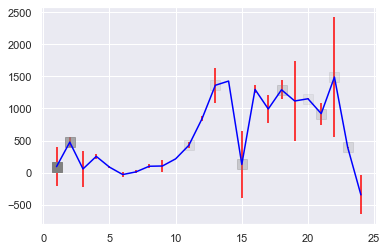

In [124]:
plot_explanation(rocket_exp, X_test[idx], X_test_err[idx], y_test[idx], multiplier=10)

In [5]:
from sklearn.metrics import accuracy_score

class MyUSAST:
    def __init__(self, min_shp_length, max_shp_length, clf):
        self.usast = USAST(cand_length_list=np.arange(min_shp_length, max_shp_length+1, 1),
                     nb_inst_per_class=2, shp_step=1,
                     random_state=None, classifier=clf, radius=0.25, use_count=False, drop_duplicates=True, scale_before_fit=True)
    
    def fit(self, X, y):
        half = X.shape[1] // 2
        X_train, X_train_err = X[:, :half], X[:, -half:]
        self.usast.init_usast(X_train, X_train_err, y)
        self.usast.fit(X_train, X_train_err, y)        
        return self
    
    def predict(self, X):
        half = X.shape[1] // 2
        X_train, X_train_err = X[:, :half], X[:, -half:]
        return self.usast.predict(X_train, X_train_err)
    
    def predict_proba(self, X):
        half = X.shape[1] // 2
        X_train, X_train_err = X[:, :half], X[:, -half:]
        return self.usast.predict_proba(X_train, X_train_err)
    
    def score(self, X, y):
        pred = self.predict(X)
        return accuracy_score(y, pred)
    

In [84]:
usast_clf = xgb.XGBClassifier(criterion='entropy', objective= 'binary:logistic')
min_shp_length, max_shp_length = 3, X_train.shape[1]

usast = MyUSAST(min_shp_length, max_shp_length, usast_clf)

X_train_usast = np.concatenate([X_train, X_train_err], axis=1).astype(np.float64)
X_test_usast = np.concatenate([X_test, X_test_err], axis=1).astype(np.float64)

usast.fit(X_train_usast, y_train)
score = usast.score(X_test_usast, y_test)
print("Score=", score)
idx = 0
exp = explain_test_local(usast, X_train_usast, X_test_usast[idx:idx+1], y_test[idx:idx+1])

show(exp)

/Users/michael/opt/miniconda3/envs/sast/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[16:09:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:09:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Score= 0.685131195335277


<!-- http://127.0.0.1:7001/140411265716432/ -->

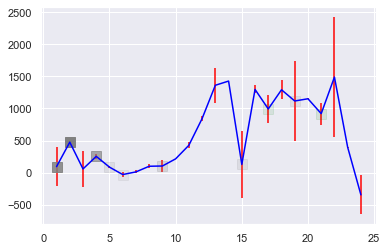

In [125]:
plot_explanation(exp, X_test[idx], X_test_err[idx], y_test[idx], multiplier=10)

# Format plasticc for XEM

In [81]:
import pandas as pd 

pd.read_parquet('../XEM/data/BasicMotions/train.parquet')

,id,timestamp,dim1,dim2,dim3,dim4,dim5,dim6,target
0,1,1,0.079106,0.394032,0.551444,0.351565,0.023970,0.633883,Standing
1,1,2,0.079106,0.394032,0.551444,0.351565,0.023970,0.633883,Standing
2,1,3,-0.903497,-3.666397,-0.282844,-0.095881,-0.319605,0.972131,Standing
3,1,4,1.116125,-0.656101,0.333118,1.624657,-0.569962,1.209171,Standing
4,1,5,1.638200,1.405135,0.393875,1.187864,-0.271664,1.739182,Standing
...,...,...,...,...,...,...,...,...,...
3995,40,96,1.239144,-6.142442,0.028264,-2.309144,1.472845,-0.998765,Badminton
3996,40,97,0.261434,0.205915,-0.224944,-0.524684,0.769715,0.157139,Badminton
3997,40,98,2.490353,-0.878765,-0.597296,0.111862,-0.117188,-0.050604,Badminton
3998,40,99,4.122120,0.911620,-0.465409,0.535338,0.197090,0.442120,Badminton


In [64]:
bands = 'gruiyz'
dataset_name = 'plassticc_5d'
dataset_folder = '/home/mimbouop/Codes/UST-Python/dataset/plasticc_5d_dataset'

def read_data(folder, dataset):
    train_ds, test_ds = load_dataset(dataset_folder, dataset)
    
    X_train, y_train = format_dataset(train_ds, shuffle=False)
    X_test, y_test = format_dataset(test_ds, shuffle=False)
    
    n, m = X_train.shape
    X_train = pd.DataFrame(data=X_train, columns=np.arange(1, m+1), index=np.arange(n)).T
    X_train = pd.concat([X_train[i] for i in X_train.columns]).to_frame()
    
    n, m = X_test.shape
    X_test = pd.DataFrame(data=X_test, columns=np.arange(1, m+1), index=np.arange(n)).T
    X_test = pd.concat([X_test[i] for i in X_test.columns]).to_frame()
    
    return X_train, y_train, X_test, y_test

X_test = {}
X_train = {}
y_test, y_train = None, None

for b in bands:
	print('#########> Reading band:', b)
	X_train[b], y_train, X_test[b], y_test = read_data(dataset_folder, f'{dataset_name}_{b}')
	print(X_train[b].shape)

#########> Reading band: g
(1638558, 1)
#########> Reading band: r
(1638558, 1)
#########> Reading band: u
(1638558, 1)
#########> Reading band: i
(1638558, 1)
#########> Reading band: y
(1638558, 1)
#########> Reading band: z
(1638558, 1)


In [74]:
df_train = pd.concat([X_train[b][0] for b in bands], axis=1)
df_train.columns = [f'dim{i+1}' for i in range(6)]
df_train.index.name = 'timestamp'
df_train = df_train.reset_index()
df_train.insert(loc=0, column='id', value=df_train.index.map(lambda i: i//261 + 1))
df_train['target'] = df_train.id.apply(lambda i: f'class_{y_train[i-1]}')
df_train.to_parquet('../XEM/data/plasticc/train.parquet')

In [72]:
df_test = pd.concat([X_test[b][0] for b in bands], axis=1)
df_test.columns = [f'dim{i+1}' for i in range(6)]
df_test.index.name = 'timestamp'
df_test = df_test.reset_index()
df_test.insert(loc=0, column='id', value=df_test.index.map(lambda i: i//261 + 1))
df_test['target'] = df_test.id.apply(lambda i: f'class_{y_test[i-1]}')
df_test.to_parquet('../XEM/data/plasticc/test.parquet')

In [76]:
df_test

,id,timestamp,dim1,dim2,dim3,dim4,dim5,dim6,target
0,1,1,-0.107919,0.750495,1.709912,-0.460703,5.844707,1.241461,class_90
1,1,2,-0.185620,0.725342,1.600806,-0.430018,5.950078,1.316295,class_90
2,1,3,-0.276813,0.692135,1.475886,-0.400813,6.062594,1.394908,class_90
3,1,4,-0.383491,0.649266,1.333219,-0.373995,6.182254,1.476977,class_90
4,1,5,-0.507880,0.594862,1.170726,-0.350695,6.308908,1.562014,class_90
...,...,...,...,...,...,...,...,...,...
409765,1570,257,-1.184081,-1.696983,1.912532,-2.128673,-4.644942,-0.872710,class_15
409766,1570,258,-1.023492,-1.522019,2.056777,-1.947457,-4.471168,-0.692710,class_15
409767,1570,259,-0.022315,-0.454391,2.980419,-0.851407,-3.408897,0.397837,class_15
409768,1570,260,-0.022315,-0.454391,2.980419,-0.851407,-3.408897,0.397837,class_15
